# Step 1. 작업환경 구성하기

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델 구조를 이용해 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 보는 프로젝트를 진행해 보고자 한다. 이번 프로젝트는 훈련하는 데 시간이 오래 걸리는 만큼 Colab에서 GPU를 켜고 실행하려고 했으나 이미지 생성 모델을 애니메이션화한 파일을 불러들이는 마지막 부분에서 에러가 계속해서 뜨는 바람에 할 수 없이 주피터 노트북으로 작업하였다. 또한 참고가 될 만한 좋은 블로그의 내용을 대부분의 내용을 인용했다.

이미지 모델 구현 프로젝트 참고 링크 : https://zzcojoa.tistory.com/88?category=1035878

```
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history
```

먼저 다음의 명령어를 cloud shell에 입력하여 작업환경을 구성해 준다.

In [1]:
# 필요한 라이브러리 불러들이기 및 버전 확인
import tensorflow as tf
import imageio

import os
import glob
import time

import PIL
import numpy as np
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)
print("imageio", imageio.__version__)

tensorflow 2.6.0
imageio 2.9.0


# Step 2. 데이터셋 구성

CIFAR-10 데이터셋도 tf.keras 안에 있는 dataset에 포함되어 있어서 아래와 같은 명령어 만으로 쉽게 데이터셋 구성이 가능하다.

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print(train_x.shape)
print(test_x.shape)

170508288/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


근데 몇 가지 달라지는 점이 있으니 우선 이 점을 정리해 볼 필요가 있어 적어 놨다.

* 이미지의 데이터 shape가 (28, 28, 1)에서 (32, 32, 1)로 변경되다 보니 생성자, 판별자, 입출력 shape 및 모델 구조에 영향이 있을 수 있다.

* 이미지가 단색의 grayscale에서 RGB 3채널의 컬러 이미지로 변경된다. 시각화 과정에서 고려해야 할 대상이다.

* 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라진다.

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


32 X 32짜리 픽셀 이미지의 각 픽셀은 0 ~ 255 사이의 정숫값을 가진다. 그리고 max와 min 값이 예상했던 대로 출력이 되는 것을 확인할 수 있었다.
각 픽셀을 조건에 맞도록 -1, 1로 정규화 시켜서 사용할 예정이다. 때문에 중간값을 0으로 맞춰줘야 하고 그렇게 하려면 127.5를 뺀 후 127.5로 나눠주면 된다.

In [4]:
train_x = (train_x - 127.5) / 127.5  # 이미지를 [-1, 1]로 정규화

print("max pixel :", train_x.max())
print('min pixel :', train_x.min())

max pixel : 1.0
min pixel : -1.0


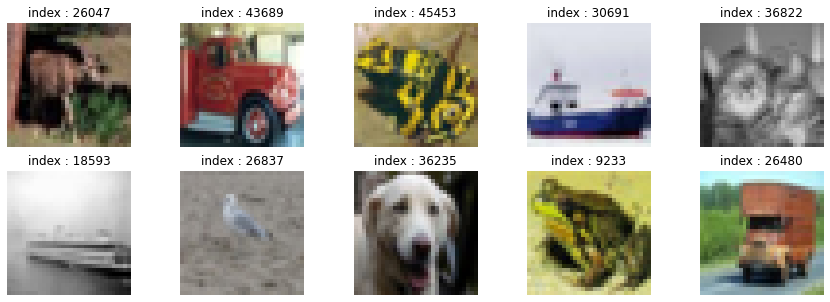

In [5]:
plt.figure(figsize=(15,5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index] + 1) / 2)
    plt.title(f'index : {random_index}')
    plt.axis('off')
plt.show()

데이터 전처리를 모두 마쳤으니, 이 데이터를 곧 모델에 넣어서 학습시킬 차례이다. 편하게 사용할 수 있도록 텐서플로우의 Dataset을 이용해 준비한다.이를 이용하면 우리가 매번 모델에게 직접 섞어서 넣어주지 않아도 된다.

In [6]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

BUFFER_SIZE는 전체 데이터를 섞기 위해 50,000으로 설정한다. shuffle() 함수가 데이터셋을 잘 섞어서 모델에 넣을 것이다.

BATCH_SIZE는 모델이 한 번에 학습하게 되는 데이터의 양이다. 너무 많은 양을 한번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데도 오래 걸리기 때문에 적절한 사이즈를 책정해 주는 것이 중요하다. 이러한 방식을 미니 배치 학습이라고 한다.

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다. 위 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 한다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋다.

# Step 3. 생성자 모델 구현하기

* (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성하는 순서이다.
* noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 보자.
* 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인까지.

In [8]:
def make_generator_model():

  # Start
  model = tf.keras.Sequential()

  # First: Dense layer
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Second : Reshape layer
  model.add(layers.Reshape((8,8,256)))

  # Third : Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(128,
                                   kernel_size=(5,5),
                                   strides=(1,1),
                                   padding='same',
                                   use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Fourth : Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(64,
                                   kernel_size=(5,5),
                                   strides=(2,2),
                                   padding='same',
                                   use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Fifth : Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(3,
                                   kernel_size=(5, 5),
                                   strides=(2, 2),
                                   padding='same',
                                   use_bias=False, \
                                   activation='tanh'))

  return model

In [9]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

모델까지 만들어졌고, 이제는 shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성해서 결과물을 한번 만들어 보자.
아직 모델이 학습되지 않았으니, 아마 결과물도 큰 의미가 있지는 않을 것 같다.

tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있다.

텐서플로우 2.0 이후 버전에서는 레이어와 모델에 call 메소드를 구현해 놓기 때문에, 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 형성된다.(내부적으로는 생성자의 call 함수가 호출된다.)

단, 지금은 학습하는 중이 아니니 training=False를 설정해 주어야 한다!! Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 training=False을 주어야 올바른 결과를 얻을 수 있다.

In [10]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

[1, 32, 32, 3] 사이즈의 이미지가 잘 생성된 것을 확인할 수 있었다!!!

첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻을 가집니다.

그러면 이 이미지를 또 시각화해서 봐야겠습니다. matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 (32, 32) shape의 이미지를 꺼낼 수 있도록 해야 합니다.

그러면 이 이미지를 또 시각화해서 확인해 봐야 된다. matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 (32, 32) shape의 이미지를 꺼낼 수 있도록 해야 한다.

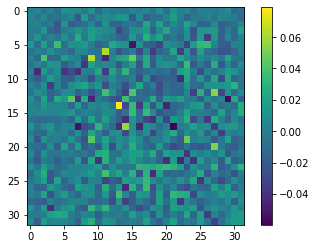

In [11]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

역시 -1과 1 사이의 값에서 적당히 잘 생성된 것을 확인할 수 있었다. 이게 아직은 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지가 생성된 것이다. 하지만 모델이 점차 학습해 나가며 제대로 된 이미지를 생성하리라고 생각된다.

# Step 4. 판별자 모델 구현하기

이번에는 판별자를 설계할 차례이다.

판별자는 앞서 알아봤듯이 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야 한다.

그럼 입력은 (32,32,3) 크기의 이미지가, 출력은 단 하나의 숫자(진짜라고 판단하는 정도)가 되어야 할 것이다.

CIFAR-10을 활용한 이미지 생성기 관련 링크 : https://zzcojoa.tistory.com/88?category=1035878

In [12]:
def make_discriminator_model():

  # Start
  model = tf.keras.Sequential()

  # First : Conv2D Layer
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # Second : Conv2D Layer
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # Third : Flatten Layer
  model.add(layers.Flatten())

  # Fourth : Dense Layer
  model.add(layers.Dense(1))

  return model

판별자 또한 make_discriminator_model 함수로 구현했다.

Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와는 반대로, 판별자는 Conv2D 층을 이용해 이미지의 크기를 점점 줄여나간다.
첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128) 까지 줄어들게 된다.

마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7 X 7 X 128 = 6272, 즉 (1, 6272) 형상의 벡터로 변환한다. 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대의 역할을 함을 알 수 있다. 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 된다.

그럼 판별 모델을 discriminator라는 변수 이름으로 생성하고, 모델 세부 내용을 확인해보자!!

In [13]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [14]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00345904]], dtype=float32)>

텐서플로우의 텐서 형태로 출력이 되었다. 이 값 또한 아직은 아무런 의미가 없을 것이다.

이제 모델 학습을 위한 루트를 천천히 밟아보자!!!

# STEP 5. 손실함수와 최적화 함수 구현하기


## 1) 손실 함수

손실함수에 사용할 교차 엔트로피 함수는 tf.keras.losses 라이브러리 안에 있다. 다만, 우리가 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없다. 즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있다는 뜻이다.

그런데 tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정한다. 따라서 from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있다.

각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같이 정리가 가능할 거 같다.
* 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
* 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### generator loss

그러면 generator_loss는 다음과 같이 구현할 수 있을 것이다.

generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 될 것이다. 즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가진다.

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator loss
반면, discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산해야 한다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 된다!

최종 discriminator_loss 값은 이 둘을 더한 값이 될 것이다.

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy

한편, 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요하다. 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용하다.

만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까? 아니다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻이다. 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻이다.

In [19]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 2) 최적화 함수
이번에는 최적화 함수를 설정할 차례이다. Adam 기법이 가장 보편적인 최적화 기법이다 보니 이번에도 역시 Adam 기법을 활용할 것이다.

Adam 또한 tf.keras.optimizers 안에 있다.
중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꿔 가며 학습을 진행해 보는 것을 권장한다.

또한, 중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점을 상기하자.

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# Step 6. 훈련과정 상세 기능 구현하기

1) 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현하기.  
2) 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현하기.  
3) 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현하기.  
4) training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈 설정.  

In [22]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

위의 훈련 코드를 단계별로 뜯어보면 다음과 같다!!

(1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음  
(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함  
(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기  
(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성  
(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력  
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산  
(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산  
(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산  
(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신  
(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴  

이러한 일련의 과정을 통해 한 번의 train_step이 끝나게 된다!!!

그러면, 이렇게 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만들여 보자. 아까 만들어 놓았던 고정된 seed를 이용해 결과물을 만들어내므로 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있다.

In [23]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i] * 127.5 +127.5).astype('uint8'))
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
    plt.show()

In [24]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [25]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Step 7. 학습 과정 진행하기


* 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
* 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
* 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출해야 한다!!!!

In [26]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [27]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

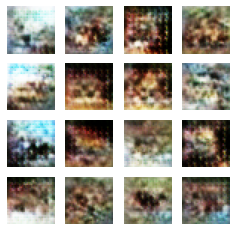

Time for training : 740 sec


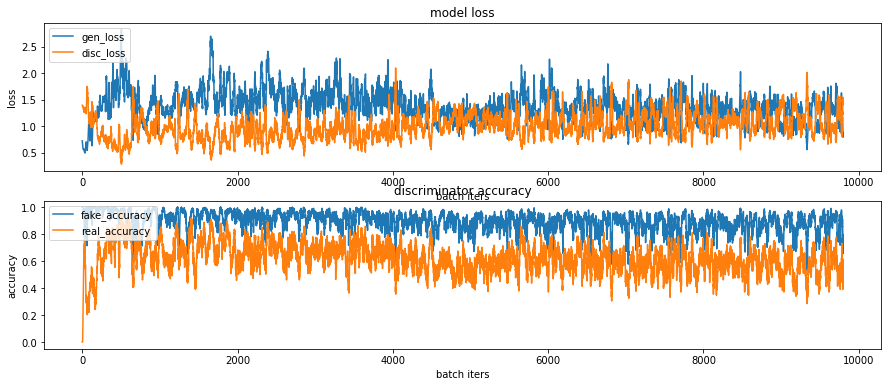

CPU times: user 12min 44s, sys: 1min 17s, total: 14min 1s
Wall time: 12min 21s


In [61]:
%%time
train(train_dataset, EPOCHS, save_every)

In [62]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1103261 Aug 29 11:59 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


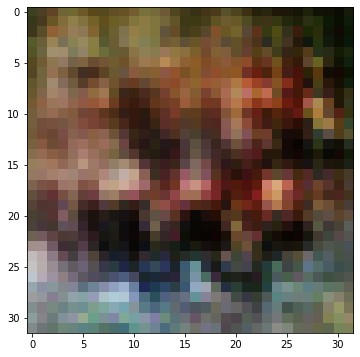

In [63]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

# Step 8. GAN 훈련 과정 

STEP 6과 7을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봤더니, 이미지가 완전히 흐릿하게 나온 것이 전혀 우리가 원하던 그럴듯한 이쁜 이미지의 형태가 나오지 않았다. 이를 위해서 기존에 세운 모델에 추가할 것은 추가하고 하이퍼 파라미터를 수정하면서 우리가 원하는 형태의 이미지를 생성해 보고자 한다.

## 첫 번째 수정안

In [28]:
def make_generator_model_2():

  # Start
  model = tf.keras.Sequential()

  # First: Dense layer
  model.add(layers.Dense(8*8*128, activation='relu', input_shape=(100,)))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  # Second : Reshape layer
  model.add(layers.Reshape((8,8,128)))

  # Third : Conv2D layer
  model.add(layers.Conv2D(128, kernel_size=4, strides=1, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))
  
  # Fourth : Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  # Fifth : Conv2D layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))
  
  # Sixth : Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  # Seventh : Conv2D layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))
    
  # Eighth : Conv2D layer
  model.add(layers.Conv2D(3, kernel_size=5, strides=1, padding='same', activation='tanh'))

  return model

CS231 7강 Training Neural Network에서 나왔던 개념 중에 모멘텀이라는 개념을 활용했다는 것을 알 수 있다. 이렇게 하면 parameter가 진동하는 것을 줄임으로써 변동을 줄이고
Gradient Descent보다 빠르게 수렴하기 때문에 더 효율적으로 이미지 생성 모델을 구현할 수 있을 것이라는 기대를 했다.

CS231 7강 요약본(모멘텀에 관한 내용) 참조 블로그 주소 : https://velog.io/@cha-suyeon/cs231n-7%EA%B0%95-%EC%A0%95%EB%A6%AC-Training-Neural-Networks-II

In [29]:
generator_2 = make_generator_model_2()

generator_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_3 (Batch (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)        

In [30]:
# 노이즈 생성
noise = tf.random.normal([1, 100])
generated_image = generator_2(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [31]:
def make_discriminator_model_2():

  # Start
  model = tf.keras.Sequential()

  # First : Conv2D Layer
  model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=(32, 32, 3), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.1))
  model.add(layers.Dropout(0.3))

  # Second : Conv2D Layer
  model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))  
  model.add(layers.LeakyReLU(alpha=0.1))
  model.add(layers.Dropout(0.3))
    
  # Third : Conv2D Layer
  model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))  
  model.add(layers.LeakyReLU(alpha=0.1))
  model.add(layers.Dropout(0.3))

  # Fourth : Conv2D Layer
  model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))  
  model.add(layers.LeakyReLU(alpha=0.1))
  model.add(layers.Dropout(0.3))
    
  # Fifth : Flatten Layer
  model.add(layers.Flatten())

  # Sixth : Dense Layer
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

참고한 블로그에서는 모멘텀을 0.8에 alpha 값을 0.2로 줬었는데, 저의 경우는 모멘텀을 생성자 모델을 만들 때와 동일하게 모멘텀을 0.9, alpha 값을 0.1로 주기로 했다.

In [32]:
discriminator_2 = make_discriminator_model_2()

discriminator_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 64)         

In [33]:
save_every = 5
EPOCHS = 300

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

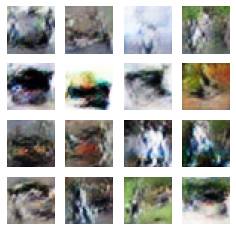

Time for training : 5109 sec


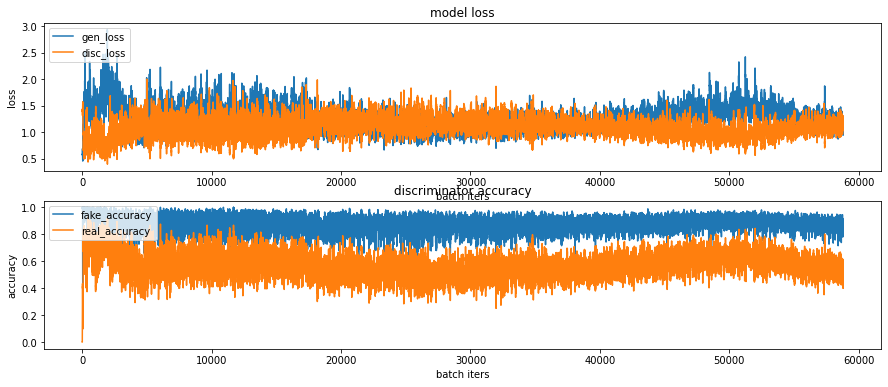

CPU times: user 1h 26min 47s, sys: 8min, total: 1h 34min 47s
Wall time: 1h 25min 13s


In [34]:
%%time
train(train_dataset, EPOCHS, save_every)

## 두 번째 수정안

첫 번째 수정안에서 좀 더 업그레이드된 버전이라고 할 수 있을 거 같다. 우선 생성자 모델을 먼저 구현해 보자.

In [37]:
# 생성자 모델 구현 - 3
def make_generator_model_3():
    
    model = tf.keras.Sequential()
    
    # First : Dense Layer
    model.add(layers.Dense(8*8*128, activation='relu', input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Seond : Reshape Layer
    model.add(layers.Reshape((8, 8, 128)))
    
    # Third : Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Fourth : Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Fifth: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Sixth : Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Seventh : Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Eighth : Conv2D Layer
    model.add(layers.Conv2D(3, kernel_size=5, strides=1, padding='same', activation='tanh'))
    
    return model

In [38]:
generator_3 = make_generator_model_3()

generator_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_18 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         262272    
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 8, 8, 128)        

In [39]:
# 노이즈 생성
noise = tf.random.normal([1, 100])
generated_image = generator_2(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

생성자 모델 및 노이즈 생성까지는 첫 번째 수정안 때와 동일하게 적용한다. 하지만 판별자 모델을 만들 때 약간의 변화를 주었다. Conv2D 레이어를 추가할 때 첫 번째 수정안과 달리 필터값을 128로 동일하게 맞추고, 커널 사이즈와 보폭(strides)에도 변화를 가했다. dense layer 역시 추가를 시켜 봤다.

In [45]:
# 판별자 모델 구현 - 3
def make_discriminator_model_3():
    
    # Start
    model = tf.keras.Sequential()
    
    # First Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=3, strides=1, input_shape=(32,32,3), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Second Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Third Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Fourth Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Fifth Flatten Layer
    model.add(layers.Flatten())
    
    # Sixth Dense Layer
    model.add(layers.Dense(512, activation='relu'))
    
    # Eighth Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [46]:
discriminator_3 = make_discriminator_model_3()

discriminator_3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_24 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 16, 16, 128)      

In [48]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.5)

In [49]:
BUFFER_SIZESIZE = 50000
BATCH_SIZE = 16

In [50]:
save_every = 5
EPOCHS = 100

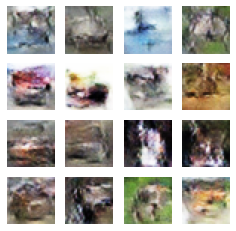

Time for training : 1613 sec


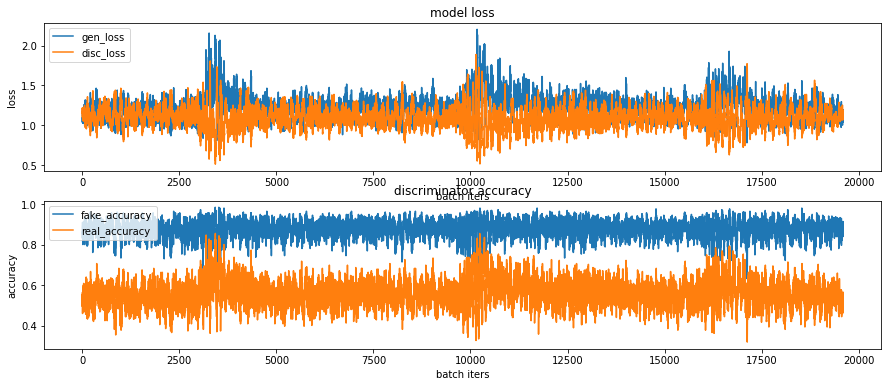

CPU times: user 27min 30s, sys: 2min 36s, total: 30min 7s
Wall time: 26min 55s


In [51]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

## 세 번째 수정안

이미지의 형태로만 본다면 아까보다는 제법 사진다운 사진이 나온 것처럼 보이지만 제일 중요한 fake accuracy가 우하향하는 경향이 전혀 보이지 않아 진짜 같은 가짜 이미지를 만드는 데에는 결과론적으로는 실패한 듯하다. 두 번째 수정 모델의 전체적인 내용은 그대로 한 채 batch_size나 학습률 등을 조정하는 방법을 모색해 봤다. 에포크도 200까지 줘 봤다.

In [52]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5)

In [53]:
BUFFER_SIZESIZE = 50000
BATCH_SIZE = 64

In [54]:
save_every = 5
EPOCHS = 200

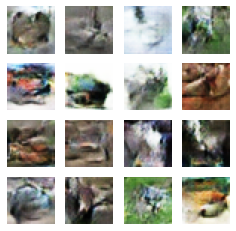

Time for training : 3305 sec


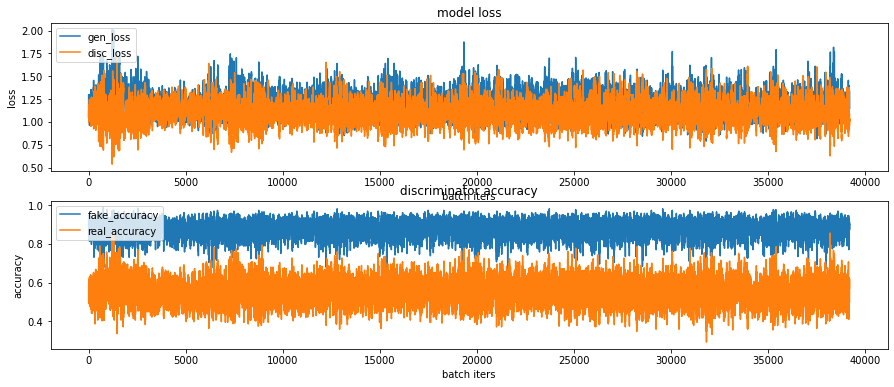

CPU times: user 56min 31s, sys: 5min 16s, total: 1h 1min 48s
Wall time: 55min 8s


In [55]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

## 4번째 수정안

이번에는 판별자 모델 내에서 dropout을 0.3에서 0.25만큼만 주고 실행을 해 봤다.

In [56]:
# 판별자 모델 구현 - 3
def make_discriminator_model_4():
    
    # Start
    model = tf.keras.Sequential()
    
    # First Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=3, strides=1, input_shape=(32,32,3), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    # Second Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    # Third Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))
    
    # Fourth Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    # Fifth Flatten Layer
    model.add(layers.Flatten())
    
    # Sixth Dense Layer
    model.add(layers.Dense(512, activation='relu'))
    
    # Eighth Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [58]:
discriminator_4 = make_discriminator_model_4()

discriminator_4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_29 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 16, 16, 128)      

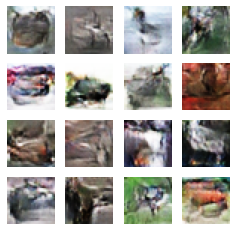

Time for training : 3329 sec


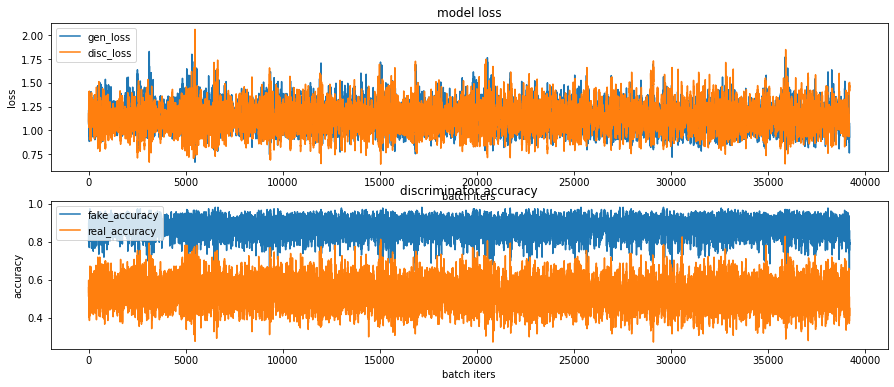

CPU times: user 56min 40s, sys: 5min 16s, total: 1h 1min 57s
Wall time: 55min 32s


In [57]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

## 5번째 수정안

다시 판별자 모델에서 필터 수를 변경해서 실행해 봤다.

In [65]:
# 판별자 모델 구현 - 5
def make_discriminator_model_5():
    
    # Start
    model = tf.keras.Sequential()
    
    # First Conv2D Layer
    model.add(layers.Conv2D(32, kernel_size=3, strides=1, input_shape=(32,32,3), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    # Second Conv2D Layer
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    # Third Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))
    
    # Fourth Conv2D Layer
    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    # Fifth Flatten Layer
    model.add(layers.Flatten())
    
    # Sixth Dense Layer
    model.add(layers.Dense(512, activation='relu'))
    
    # Eighth Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [66]:
discriminator_5 = make_discriminator_model_5()

discriminator_5.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_40 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 64)        32832     
_________________________________________________________________
batch_normalization_41 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 16, 16, 64)      

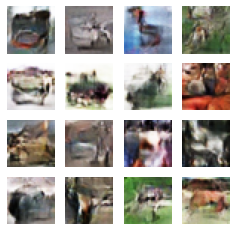

Time for training : 3299 sec


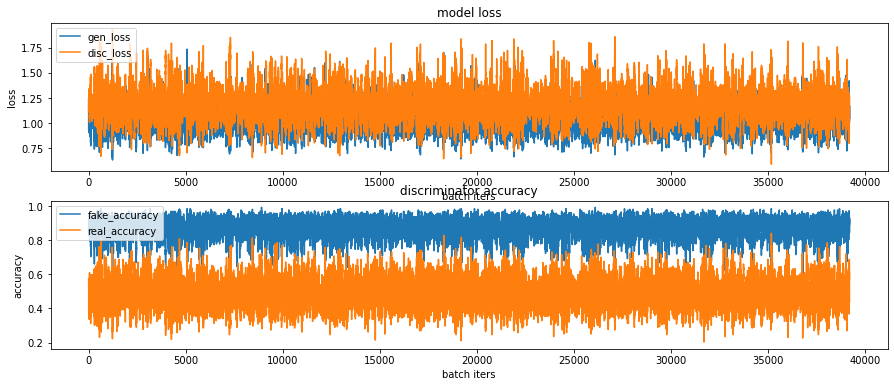

CPU times: user 56min 18s, sys: 5min 17s, total: 1h 1min 35s
Wall time: 55min 2s


In [67]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

# 회고

* 이 노드는 CIFAR-10 데이터셋에 있는 10,000장 대의 이미지를 기억하고 이 이미지와 유사한 새로운 이미지를 생성해내는 모델을 구현하는 노드라는 개략적인 개념을 이해할 수 있었다.  

* 이 프로젝트에서 중요한 부분은 discrimination accuracy 그래프에서 fake accuracy(가짜 사진 혹은 생성된 이미지의 정확도)가 0.5로 우하향을 하는 형태의 그래프로, real accuracy(원래 사진의 정확도)는 0.5로 우상향을 하여 두 개의 그래프가 겹치는 형태의 그래프로 나오는 것이 가장 이상적인 이미지 생성 모델이라고 하는 배경지식이었다. 이 말뜻은 판별자가 생성한 이미지가 진짜인듯 진짜아닌 진짜같은, 정말 판별자가 가늠하기 힘든 진짜 같은 가짜 이미지를 생성했다는 것을 의미한다~~  

* 처음 이미지 생성 모델을 훈련할 때는 이미지 같지 않는 픽셀 단위의 알 수 없는 이미지가 나왔고 이를 develope하기 위한 다양한 GAN 향상 모델을 구현했지만 한 번 훈련에 시간을 기본적으로 1시간 이상씩 소비하다 보니 내 생각만큼 다양한 모델을 구현해 내기에는 시간이 다소 모자르다는 생각이 들었다.  

* 이 과정에서 하이퍼 파라미터라고 할 수 있는 모멘텀, 학습률 등등을 추가하고 batch size까지 살짝 조정을 해 봤지만 이상적인 이미지 생성 모델(discrimination accuracy에서 fake accuracy가 우하향하는 그래프를 형성하는 모델)을 만들어 내지 못한 듯하다. 이미지 자체로 보면 무슨 동물 이미지가 구현이 된 거 같지만 말이다.  

* 종합적으로 다소 아쉬운, 그리고 상당히 어려우면서도 시간을 많이 소비하게 되는 노드였지만 이미지 생성과 관련된 이번 노드는 내가 하고자 하는 직무를 탐색하는 데 많은 도움을 줬던 노드로 회자될 듯 싶다.  